## 时间滚动框架

In [1]:
from sklearn.linear_model import HuberRegressor, ElasticNet
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from skopt import BayesSearchCV
from skopt.space import Real
from tqdm import tqdm
import numpy as np
import gc
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.linear_model import LinearRegression  
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
import pandas as pd

In [2]:
# 自定义 R2 分数计算函数
def custom_r2_score(y_true, y_pred):
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum(y_true ** 2)
    return 1 - numerator / denominator

def time_rolling_cv(models, start_year=2010, end_year=2017, ignore_unstable_features=False):
    results = {model_name: {"r2_scores": [], "params": [], "feature_counts": []} for model_name in models.keys()}
    unstable_features = ["RET", "RF", "VOL_ISS"]

    for model_name, model_info in models.items():
        all_y_test = []
        all_y_pred = []

        for year in tqdm(range(start_year, end_year + 1)):
            train_data = pd.read_csv(f'dataset/2008-{year}train_data.csv')
            val_data = pd.read_csv(f'dataset/2008-{year}val_data.csv')
            test_data = pd.read_csv(f'dataset/2008-{year}test_data.csv')

            # 忽略不稳定特征
            if ignore_unstable_features:
                train_data.drop(columns=unstable_features, errors='ignore', inplace=True)
                val_data.drop(columns=unstable_features, errors='ignore', inplace=True)
                test_data.drop(columns=unstable_features, errors='ignore', inplace=True)

            X_train, y_train = train_data.drop(columns='EX_RET_AHD'), train_data['EX_RET_AHD']
            X_val, y_val = val_data.drop(columns='EX_RET_AHD'), val_data['EX_RET_AHD']
            X_test, y_test = test_data.drop(columns='EX_RET_AHD'), test_data['EX_RET_AHD']

            X_combined = np.vstack((X_train, X_val))
            y_combined = np.concatenate((y_train, y_val))
            test_fold = np.array([-1] * len(X_train) + [0] * len(X_val))
            ps = PredefinedSplit(test_fold)

            del X_val, y_val, train_data, val_data, test_data
            gc.collect()

            model, param_grid = model_info["model"], model_info["param_grid"]
            search_cv = model_info.get("search_cv", GridSearchCV)

            grid_search = search_cv(model, param_grid, cv=ps)
            grid_search.fit(X_combined, y_combined)

            best_model = grid_search.best_estimator_
            best_model.fit(X_train, y_train)

            y_pred = best_model.predict(X_test).ravel()
            y_train_pred = best_model.predict(X_train).ravel()

            # 确保 y_train 和 y_test 也是一维的
            y_train = y_train.ravel()
            y_test = y_test.ravel()

            all_y_test.extend(y_test)
            all_y_pred.extend(y_pred)

            # 使用自定义的R²得分
            r2_in_sample = custom_r2_score(y_train, y_train_pred)
            r2_out_of_sample = custom_r2_score(y_test, y_pred)
            results[model_name]["r2_scores"].append((year, r2_in_sample, r2_out_of_sample))

            # 记录超参数
            results[model_name]["params"].append((year, grid_search.best_params_))

            # 记录特征数量
            feature_count = X_train.shape[1]
            results[model_name]["feature_counts"].append((year, feature_count))

            del X_train, y_train, X_test, y_test, X_combined, y_combined
            gc.collect()

        # 计算自定义R²
        r2_custom = custom_r2_score(np.array(all_y_test), np.array(all_y_pred))
        results[model_name]["r2_scores"].append(("Overall", r2_custom))

    return results


In [4]:
models = {
    # 1. 简单线性回归
    "Linear Regression": {
        "model": LinearRegression(),
        "param_grid": {}
    },
    # 2. Huber回归
    "Huber Regression": {
        "model": HuberRegressor(),
        "param_grid": {}
    },
    # 3. Elastic Net（使用Huber损失）
    "Elastic Net (Huber)": {
        "model": ElasticNet(),
        "param_grid": {
            'alpha': Real(0.01, 0.9),
            'l1_ratio': Real(0.01, 0.9)
        },
        "search_cv": BayesSearchCV
    },
    # 更新Elastic Net 以使用贝叶斯优化
    "Elastic Net": {
        "model": ElasticNet(),
        "param_grid": {
            'alpha': Real(0.01, 0.9),
            'l1_ratio': Real(0.01, 0.9)
        },
        "search_cv": BayesSearchCV
    },
    # 5. 主成分回归 (PCR)
    "PCR": {
        "model": make_pipeline(PCA(), LinearRegression()),
        "param_grid": {
            'pca__n_components': np.arange(5, 30, dtype='int')
        }
    },
    # 6. 偏最小二乘法 (PLS)
    "PLS": {
        "model": PLSRegression(),
        "param_grid": {
            'n_components': [5, 10, 15, 20, 25]
        }
    }
}

In [3]:
# 定义模型
models_OLS = {
    "Linear Regression": {
        "model": LinearRegression(),
        "param_grid": {}
    }
}

# 执行并打印结果
r2_scores_OLS = time_rolling_cv(models_OLS, start_year=2010, end_year=2017, ignore_unstable_features=True)
for model_name, info in r2_scores_OLS.items():
    print(f"{model_name}:")
    print(" R² Scores:", info["r2_scores"])
    print(" Parameters:", info["params"])
    print(" Feature Counts:", info["feature_counts"])

In [6]:
models_HB = {
    # 2. Huber回归
    "Huber Regression": {
        "model": HuberRegressor(),
        "param_grid": {}
    }
}

r2_scores_HB = time_rolling_cv(models_HB, start_year=2010, end_year=2017, ignore_unstable_features=True)
for model_name, info in r2_scores_HB.items():
    print(f"{model_name}:")
    print(" R² Scores:", info["r2_scores"])
    print(" Parameters:", info["params"])
    print(" Feature Counts:", info["feature_counts"])

D:\python\Lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\python\Lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\python\Lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:

Huber Regression:
 R² Scores: [(2010, 0.10135442616639534, 0.03233792524794943), (2011, 0.06671480927417972, -0.005235667422934576), (2012, 0.08226003755438849, -0.015016130370796965), (2013, 0.06548012323904917, 0.0030695854841427117), (2014, 0.06549326818176882, -0.019790367348562876), (2015, 0.05885293709037087, -0.015986527940480277), (2016, 0.05548148791343499, -0.0023301971791889198), (2017, 0.04955774222730169, -0.020133202128086225), ('Overall', -0.008028031880378261)]
 Parameters: [(2010, {}), (2011, {}), (2012, {}), (2013, {}), (2014, {}), (2015, {}), (2016, {}), (2017, {})]
 Feature Counts: [(2010, 36), (2011, 36), (2012, 36), (2013, 36), (2014, 36), (2015, 36), (2016, 36), (2017, 36)]


In [9]:
from sklearn.linear_model import ElasticNet
models_EN = {
    "Elastic Net": {
        "model": ElasticNet(),
        "param_grid": {
            'alpha': Real(0, 0.9),
            'l1_ratio': Real(0, 1)
        },
        "search_cv": BayesSearchCV
    }
}

result_EN = time_rolling_cv(models_EN, start_year=2010, end_year=2017, ignore_unstable_features=True)
for model_name, info in result_EN.items():
    print(f"{model_name}:")
    print(" R² Scores:", info["r2_scores"])
    print(" Parameters:", info["params"])
    print(" Feature Counts:", info["feature_counts"])

D:\python\Lib\site-packages\sklearn\model_selection\_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
D:\python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.850e+03, tolerance: 4.140e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
D:\python\Li

Elastic Net:
 R² Scores: [(2010, 0.08705122839747692, 0.06355678646122798), (2011, 0.07046093714504986, 0.021682115839567473), (2012, 0.07830986939054618, 0.04104783562015779), (2013, 0.06286549975478495, 0.009356184176741777), (2014, 0.06591835353528608, 0.01276069455491724), (2015, 0.06373800119995965, 0.013520889230254296), (2016, 0.060236163232135875, 0.02025089755298748), (2017, 0.05535813462800865, 0.0149678316642059), ('Overall', 0.022224494641687298)]
 Parameters: [(2010, OrderedDict([('alpha', 0.046143272835068805), ('l1_ratio', 0.21610623632558076)])), (2011, OrderedDict([('alpha', 0.0022630968080304295), ('l1_ratio', 0.5097491426048897)])), (2012, OrderedDict([('alpha', 0.03554324870482688), ('l1_ratio', 0.20900189105728867)])), (2013, OrderedDict([('alpha', 0.08868886509897067), ('l1_ratio', 0.03350057744239399)])), (2014, OrderedDict([('alpha', 0.007136543303066267), ('l1_ratio', 0.7689035225674226)])), (2015, OrderedDict([('alpha', 0.0), ('l1_ratio', 0.7991280051989335)])

In [4]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class ElasticNetWithHuber(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=1.0, l1_ratio=0.5, max_iter=1000, sigma=1.0, delta=1.0, learning_rate=0.01):
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.max_iter = max_iter
        self.sigma = sigma
        self.delta = delta
        self.learning_rate = learning_rate

    def _calculate_huber_gradient(self, X, y, y_pred):
        # Huber 梯度计算方法
        error = (y - y_pred) / self.sigma
        abs_error = np.abs(error)
        mask = abs_error <= self.delta
        gradient = -np.dot(X[mask].T, error[mask]) / len(X)
        gradient += -np.dot(X[~mask].T, np.sign(error[~mask]) * self.delta) / len(X)
        return gradient

    def fit(self, X, y):
        # 初始化系数
        self.coef_ = np.zeros(X.shape[1])
        # 迭代优化
        for _ in range(self.max_iter):
            y_pred = X.dot(self.coef_)
            gradient = self._calculate_huber_gradient(X, y, y_pred)
            self.coef_ -= self.learning_rate * gradient
        return self

    def predict(self, X):
        return X.dot(self.coef_)

    def get_params(self, deep=True):
        return {"alpha": self.alpha, "l1_ratio": self.l1_ratio, "max_iter": self.max_iter,
                "sigma": self.sigma, "delta": self.delta, "learning_rate": self.learning_rate}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


# 现在可以这样使用你的自定义模型：
models_ENHB = {
    "Elastic Net (Huber)": {
        "model": ElasticNetWithHuber(),
        "param_grid": {
            'alpha': Real(0.01, 0.9),
            'l1_ratio': Real(0.01, 0.9)
        },
        "search_cv": BayesSearchCV
    }
}

r2_scores_ENHB = time_rolling_cv(models_ENHB, start_year=2010, end_year=2017, ignore_unstable_features=True)
for model_name, info in r2_scores_ENHB.items():
    print(f"{model_name}:")
    print(" R² Scores:", info["r2_scores"])
    print(" Parameters:", info["params"])
    print(" Feature Counts:", info["feature_counts"])

  0%|          | 0/8 [00:00<?, ?it/s]D:\python\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\python\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\python\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
 12%|█▎        | 1/8 [01:38<11:32, 98.95s/it]D:\python\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\python\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\pytho

Elastic Net (Huber):
 R² Scores: [(2010, 0.09878108632808713, 0.05663427298484769), (2011, 0.0677576564839516, 0.0270099096323263), (2012, 0.08280116496044443, 0.03539786021068303), (2013, 0.066413650339741, 0.007010529772209395), (2014, 0.06663438610647232, -0.0004812852009055124), (2015, 0.0609197649821569, -0.02481558458958144), (2016, 0.057529758444722745, -0.00482705281329654), (2017, 0.050805749449492676, -0.020655098061892474), ('Overall', 0.003496026070263558)]
 Parameters: [(2010, OrderedDict([('alpha', 0.3324503871358838), ('l1_ratio', 0.2970339584131007)])), (2011, OrderedDict([('alpha', 0.825607117575199), ('l1_ratio', 0.7011984444345537)])), (2012, OrderedDict([('alpha', 0.3753452445772705), ('l1_ratio', 0.0794689071513658)])), (2013, OrderedDict([('alpha', 0.7990398294415084), ('l1_ratio', 0.21170565894474416)])), (2014, OrderedDict([('alpha', 0.13325960253329822), ('l1_ratio', 0.29482039582613206)])), (2015, OrderedDict([('alpha', 0.040298656692026494), ('l1_ratio', 0.24

In [7]:
models_PCR = {
    # 5. 主成分回归 (PCR)
    "PCR": {
        "model": make_pipeline(PCA(), LinearRegression()),
        "param_grid": {
            'pca__n_components': np.arange(5, 30, dtype='int')
        }
    }
}

r2_scores_PCR = time_rolling_cv(models_PCR, start_year=2010, end_year=2017, ignore_unstable_features=True)
for model_name, info in r2_scores_PCR.items():
    print(f"{model_name}:")
    print(" R² Scores:", info["r2_scores"])
    print(" Parameters:", info["params"])
    print(" Feature Counts:", info["feature_counts"])

PCR:
 R² Scores: [(2010, 0.10329054658810821, 0.045524474727194786), (2011, 0.06946533379537001, 0.01522605571474378), (2012, 0.074187655644535, 0.035585271388105855), (2013, 0.060851119361106765, 0.0009151106745364235), (2014, 0.06898113619951873, 0.006859014880793435), (2015, 0.06244790068103567, 0.006611587563821075), (2016, 0.05878960619712503, 0.015052802462423687), (2017, 0.05313650962921024, 0.010111785988351496), ('Overall', 0.015239489849791177)]
 Parameters: [(2010, {'pca__n_components': 28}), (2011, {'pca__n_components': 27}), (2012, {'pca__n_components': 20}), (2013, {'pca__n_components': 21}), (2014, {'pca__n_components': 29}), (2015, {'pca__n_components': 29}), (2016, {'pca__n_components': 29}), (2017, {'pca__n_components': 29})]
 Feature Counts: [(2010, 36), (2011, 36), (2012, 36), (2013, 36), (2014, 36), (2015, 36), (2016, 36), (2017, 36)]


In [20]:
models_PLS = {
    # 6. 偏最小二乘法 (PLS)
    "PLS": {
        "model": PLSRegression(),
        "param_grid": {
            'n_components': [5, 10, 15, 20, 25]
        }
    }
}
r2_scores_PLS = time_rolling_cv(models_PLS, start_year=2010, end_year=2017, ignore_unstable_features=True)
for model_name, info in r2_scores_PLS.items():
    print(f"{model_name}:")
    print(" R² Scores:", info["r2_scores"])
    print(" Parameters:", info["params"])
    print(" Feature Counts:", info["feature_counts"])

100%|██████████| 8/8 [00:35<00:00,  4.38s/it]

PLS:
 R² Scores: [(2010, 0.10612956260212192, 0.04800772821501764), (2011, 0.07059564195593182, 0.013655604187828518), (2012, 0.08756577172129931, 0.015838994034833687), (2013, 0.06981349135981951, 0.029448846401218587), (2014, 0.07022416849455382, 0.012763018160486306), (2015, 0.063732415678174, 0.013488060842430483), (2016, 0.06022841415789704, 0.02013895420259937), (2017, 0.055311672286301405, 0.01539845655427663), ('Overall', 0.01966887362760894)]
 Parameters: [(2010, {'n_components': 25}), (2011, {'n_components': 5}), (2012, {'n_components': 25}), (2013, {'n_components': 10}), (2014, {'n_components': 15}), (2015, {'n_components': 20}), (2016, {'n_components': 20}), (2017, {'n_components': 20})]
 Feature Counts: [(2010, 36), (2011, 36), (2012, 36), (2013, 36), (2014, 36), (2015, 36), (2016, 36), (2017, 36)]


In [15]:
GLS = make_pipeline(PolynomialFeatures(), Lasso())
models_GLM = {
    # 6. 广义线性模型 (GLM)
    "GLM": {
        "model": GLS,
    "param_grid": {
        'polynomialfeatures__degree': [2, 3],
        'lasso__alpha': [0.01, 0.05, 0.1]
        }
    }
}

r2_scores_GLM = time_rolling_cv(models_GLM, start_year=2010, end_year=2017, ignore_unstable_features=True)
for model_name, info in r2_scores_GLM.items():
    print(f"{model_name}:")
    print(" R² Scores:", info["r2_scores"])
    print(" Parameters:", info["params"])
    print(" Feature Counts:", info["feature_counts"])

 88%|████████▊ | 7/8 [20:36<04:45, 285.62s/it]D:\python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.317e+03, tolerance: 6.396e+00
  model = cd_fast.enet_coordinate_descent(
100%|██████████| 8/8 [47:42<00:00, 357.85s/it]

PLS:
 R² Scores: [(2010, 0.0301272682785535, 0.019944551917244202), (2011, 0.025679349208352464, 0.01629958363882711), (2012, 0.020035718427070526, 0.011203962040264748), (2013, 0.018284533712561557, -0.0001692749307224961), (2014, 0.016628914183294374, 0.0006313097766683651), (2015, 0.014380263020153272, -0.007187075683694699), (2016, 0.011094827198040669, 0.00012437254004460385), (2017, 0.00806346304507366, 0.00023547092711895257), ('Overall', 0.003602988960982878)]
 Parameters: [(2010, {'lasso__alpha': 0.1, 'polynomialfeatures__degree': 2}), (2011, {'lasso__alpha': 0.1, 'polynomialfeatures__degree': 2}), (2012, {'lasso__alpha': 0.1, 'polynomialfeatures__degree': 2}), (2013, {'lasso__alpha': 0.1, 'polynomialfeatures__degree': 2}), (2014, {'lasso__alpha': 0.1, 'polynomialfeatures__degree': 2}), (2015, {'lasso__alpha': 0.1, 'polynomialfeatures__degree': 2}), (2016, {'lasso__alpha': 0.1, 'polynomialfeatures__degree': 2}), (2017, {'lasso__alpha': 0.1, 'polynomialfeatures__degree': 2})]
 


## 结果保存及处理

In [11]:
import pandas as pd

class ModelComparisonData:
    def __init__(self):
        # 初始化用于存储数据的字典
        self.data = {
            "Linear Regression": {"R2_in": [], "R2_out": [], "R2_overall": None, "Feature_Count": []},
            "Huber Regression": {"R2_in": [], "R2_out": [], "R2_overall": None, "Feature_Count": []},
            "Elastic Net (Huber)": {"R2_in": [], "R2_out": [], "R2_overall": None, "Feature_Count": []},
            "Elastic Net": {"R2_in": [], "R2_out": [], "R2_overall": None, "Feature_Count": []},
            "PCR": {"R2_in": [], "R2_out": [], "R2_overall": None, "Feature_Count": []},
            "PLS": {"R2_in": [], "R2_out": [], "R2_overall": None, "Feature_Count": []},
            "Generalized Linear Model": {"R2_in": [], "R2_out": [], "R2_overall": None, "Feature_Count": []},
            "Random Forests": {"R2_in": [], "R2_out": [], "R2_overall": None, "Feature_Count": []},
            "Boosted Regression Trees": {"R2_in": [], "R2_out": [], "R2_overall": None, "Feature_Count": []}
        }
    def add_model_data(self, model_name, r2_scores, feature_counts):
        # 添加模型数据
        for data in r2_scores:
            if data[0] == 'Overall':
                self.data[model_name]["R2_overall"] = data[1]
            else:
                year, r2_in, r2_out = data
                self.data[model_name]["R2_in"].append((year, r2_in))
                self.data[model_name]["R2_out"].append((year, r2_out))
    
        for year, count in feature_counts:
            self.data[model_name]["Feature_Count"].append((year, count))

# 实例化对象
model_data = ModelComparisonData()

# 添加线性回归数据
model_data.add_model_data(
    "Linear Regression",
    [(2010, 0.10617112844189314, 0.04773029040344734), (2011, 0.07144503934760338, 0.012861995018049632), (2012, 0.08757163562184545, 0.015151284976901658), (2013, 0.070259900757917, 0.03137836708348429), (2014, 0.07026902257613765, 0.011249610118249875), (2015, 0.0637380218114395, 0.013515380626880624), (2016, 0.06023616500390294, 0.020251776532833943), (2017, 0.05536094886482179, 0.014909457411030225), ('Overall', 0.019447470903851682)],
    [(2010, None), (2011, None), (2012, None), (2013, None), (2014, None), (2015, None), (2016, None), (2017, None)]
)

# 添加Huber回归数据
model_data.add_model_data(
    "Huber Regression",
   [(2010, 0.10135442616639534, 0.03233792524794943), (2011, 0.06671480927417972, -0.005235667422934576), (2012, 0.08226003755438849, -0.015016130370796965), (2013, 0.06548012323904917, 0.0030695854841427117), (2014, 0.06549326818176882, -0.019790367348562876), (2015, 0.05885293709037087, -0.015986527940480277), (2016, 0.05548148791343499, -0.0023301971791889198), (2017, 0.04955774222730169, -0.020133202128086225), ('Overall', -0.008028031880378261)],
    [(2010, None), (2011, None), (2012, None), (2013, None), (2014, None), (2015, None), (2016, None), (2017, None)]
)

# 添加Elastic Net (Huber)数据
model_data.add_model_data(
    "Elastic Net (Huber)",
    [(2010, 0.09878108632808713, 0.05663427298484769), (2011, 0.0677576564839516, 0.0270099096323263), (2012, 0.08280116496044443, 0.03539786021068303), (2013, 0.066413650339741, 0.007010529772209395), (2014, 0.06663438610647232, -0.0004812852009055124), (2015, 0.0609197649821569, -0.02481558458958144), (2016, 0.057529758444722745, -0.00482705281329654), (2017, 0.050805749449492676, -0.020655098061892474), ('Overall', 0.003496026070263558)],
    [(2010, None), (2011, None), (2012, None), (2013, None), (2014, None), (2015, None), (2016, None), (2017, None)]
)

# 添加Elastic Net数据
model_data.add_model_data(
    "Elastic Net",
    [(2010, 0.08705122839747692, 0.06355678646122798), (2011, 0.07046093714504986, 0.021682115839567473), (2012, 0.07830986939054618, 0.04104783562015779), (2013, 0.06286549975478495, 0.009356184176741777), (2014, 0.06591835353528608, 0.01276069455491724), (2015, 0.06373800119995965, 0.013520889230254296), (2016, 0.060236163232135875, 0.02025089755298748), (2017, 0.05535813462800865, 0.0149678316642059), ('Overall', 0.022224494641687298)],
    [(2010, None), (2011, None), (2012, None), (2013, None), (2014, None), (2015, None), (2016, None), (2017, None)]
    
)


# 添加PCR数据
model_data.add_model_data(
    "PCR",
    [(2010, 0.10329054658810821, 0.045524474727194786), (2011, 0.06946533379537001, 0.01522605571474378), (2012, 0.074187655644535, 0.035585271388105855), (2013, 0.060851119361106765, 0.0009151106745364235), (2014, 0.06898113619951873, 0.006859014880793435), (2015, 0.06244790068103567, 0.006611587563821075), (2016, 0.05878960619712503, 0.015052802462423687), (2017, 0.05313650962921024, 0.010111785988351496), ('Overall', 0.015239489849791177)],
    [(2010, 28), (2011, 27), (2012, 20), (2013, 21), (2014, 29), (2015, 29), (2016, 29), (2017, 29)]
)

# 添加PLS模型数据
model_data.add_model_data(
    "PLS",
    [(2010, 0.10612956260212192, 0.04800772821501764), (2011, 0.07059564195593182, 0.013655604187828518), (2012, 0.08756577172129931, 0.015838994034833687), (2013, 0.06981349135981951, 0.029448846401218587), (2014, 0.07022416849455382, 0.012763018160486306), (2015, 0.063732415678174, 0.013488060842430483), (2016, 0.06022841415789704, 0.02013895420259937), (2017, 0.055311672286301405, 0.01539845655427663), ('Overall', 0.01966887362760894)],
    [(2010, 25), (2011, 5), (2012, 25), (2013, 10), (2014, 15), (2015, 20), (2016, 20), (2017, 20)]
)

# 添加Generalized Linear Model数据
model_data.add_model_data(
    "Generalized Linear Model",
    [(2010, 0.0301272682785535, 0.019944551917244202), (2011, 0.025679349208352464, 0.01629958363882711), (2012, 0.020035718427070526, 0.011203962040264748), (2013, 0.018284533712561557, -0.0001692749307224961), (2014, 0.016628914183294374, 0.0006313097766683651), (2015, 0.014380263020153272, -0.007187075683694699), (2016, 0.011094827198040669, 0.00012437254004460385), (2017, 0.00806346304507366, 0.00023547092711895257), ('Overall', 0.003602988960982878)],
    [(2010, None), (2011, None), (2012, None), (2013, None), (2014, None), (2015, None), (2016, None), (2017, None)]
)

# 添加Random Forests数据
model_data.add_model_data(
    "Random Forests",
    [
        (2010, 0.84100217, 0.06454206),
        (2011, 0.8075117, 0.05522043),
        (2012, 0.7832457, 0.05474776),
        (2013, 0.74912393, 0.05059481),
        (2014, 0.71688044, 0.03555828),
        (2015, 0.6723019, 0.0473296),
        (2016, 0.6429101, 0.06339008),
        (2017, 0.60143816, 0.0455724),
        ('Overall', 0.05140583)
    ],
    [
        (2010, 36),
        (2011, 36),
        (2012, 36),
        (2013, 36),
        (2014, 36),
        (2015, 36),
        (2016, 36),
        (2017, 36)
    ]
)

# 添加Boosted Regression Trees数据
model_data.add_model_data(
   "Boosted Regression Trees",
    [
        (2010, 0.2403109, 0.06556636),
        (2011, 0.2405864, 0.04587501),
        (2012, 0.17085797, 0.04488599),
        (2013, 0.1397692, 0.0525651),
        (2014, 0.24143225, 0.02788013),
        (2015, 0.26005244, 0.04562908),
        (2016, 0.2891732, 0.07474744),
        (2017, 0.26436174, 0.04972917),
        ('Overall', 0.0512732)
    ],
    [
        (2010, 36),
        (2011, 36),
        (2012, 36),
        (2013, 36),
        (2014, 36),
        (2015, 36),
        (2016, 36),
        (2017, 36)
    ]
)




def create_dataframe(data_list, columns):
    """将数据列表转换为pandas DataFrame"""
    return pd.DataFrame(data_list, columns=columns)

# 创建Excel写入器
excel_writer = pd.ExcelWriter("model_comparison.xlsx", engine='openpyxl')

# 遍历每个模型，创建DataFrame并写入对应的工作表
for model_name, model_data in model_data.data.items():
    # 创建样本内R²的DataFrame
    df_in = create_dataframe(model_data["R2_in"], columns=["Year", "R2_in"])
    df_in.to_excel(excel_writer, sheet_name=f"{model_name} R2_in", index=False)

    # 创建样本外R²的DataFrame
    df_out = create_dataframe(model_data["R2_out"], columns=["Year", "R2_out"])
    df_out.to_excel(excel_writer, sheet_name=f"{model_name} R2_out", index=False)

    # 创建总体R²的DataFrame
    df_overall = pd.DataFrame({"R2_overall": [model_data["R2_overall"]]})
    df_overall.to_excel(excel_writer, sheet_name=f"{model_name} R2_overall", index=False)

    # 创建特征数的DataFrame
    df_features = create_dataframe(model_data["Feature_Count"], columns=["Year", "Feature_Count"])
    df_features.to_excel(excel_writer, sheet_name=f"{model_name} Feature_Count", index=False)


# 保存并关闭Excel文件
excel_writer.close()

# 提示完成
print("数据已成功写入Excel文件 'model_comparison.xlsx'")


数据已成功写入Excel文件 'model_comparison.xlsx'


D:\python\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [12]:
import pandas as pd

def transform_data_corrected(sheets, metrics, overall_metric):
    """
    修正后的数据转换函数。
    :param sheets: dict, 所有工作表数据
    :param metrics: list, 需要转换的指标
    :param overall_metric: string, 总体指标的名称
    :return: dict, 每个模型转换后的数据
    """
    transformed_data = {}

    for sheet_name, sheet_data in sheets.items():
        # 提取模型名称
        model_name = sheet_name.split(' ')[0]

        # 确保模型数据存在
        if model_name not in transformed_data:
            transformed_data[model_name] = {}

        # 对于包含年份的工作表
        if 'Year' in sheet_data.columns:
            for metric in metrics:
                if metric in sheet_name:
                    transformed = sheet_data.set_index('Year')[metric].rename(model_name)
                    transformed.index = ['T' + str(i) for i in range(1, len(transformed) + 1)]
                    transformed_data[model_name][metric] = transformed
        elif overall_metric in sheet_name:
            # 对于只含总体值的工作表
            overall_value = sheet_data.iloc[0, 0]
            transformed_data[model_name][overall_metric] = pd.Series([overall_value], index=['Overall'])

    # 将所有数据合并为单个 DataFrame
    final_dfs = {}
    for model_name, data in transformed_data.items():
        final_dfs[model_name] = pd.DataFrame(data)

    return final_dfs

# 读取文件
model_comparison_path = 'model_comparison.xlsx'  # 修改为文件的实际路径
output_path = 'output.xlsx'  # 修改为文件的实际路径

# 读取 model_comparison.xlsx 的所有工作表
xls = pd.ExcelFile(model_comparison_path)
model_comparison_sheets = {sheet_name: xls.parse(sheet_name) for sheet_name in xls.sheet_names}

# 定义需要转换的指标
metrics = ['R2_in', 'R2_out']
overall_metric = 'R2_overall'

# 应用转换
transformed_model_data = transform_data_corrected(model_comparison_sheets, metrics, overall_metric)

# 保存或处理转换后的数据
# 例如，可以将其保存为新的 Excel 文件或进行进一步的分析
# 这里仅作为示例显示第一个模型的转换后数据
example_model = list(transformed_model_data.keys())[0]
transformed_model_data[example_model].to_csv('transformed_data.csv')  # 将数据保存为 CSV 文件


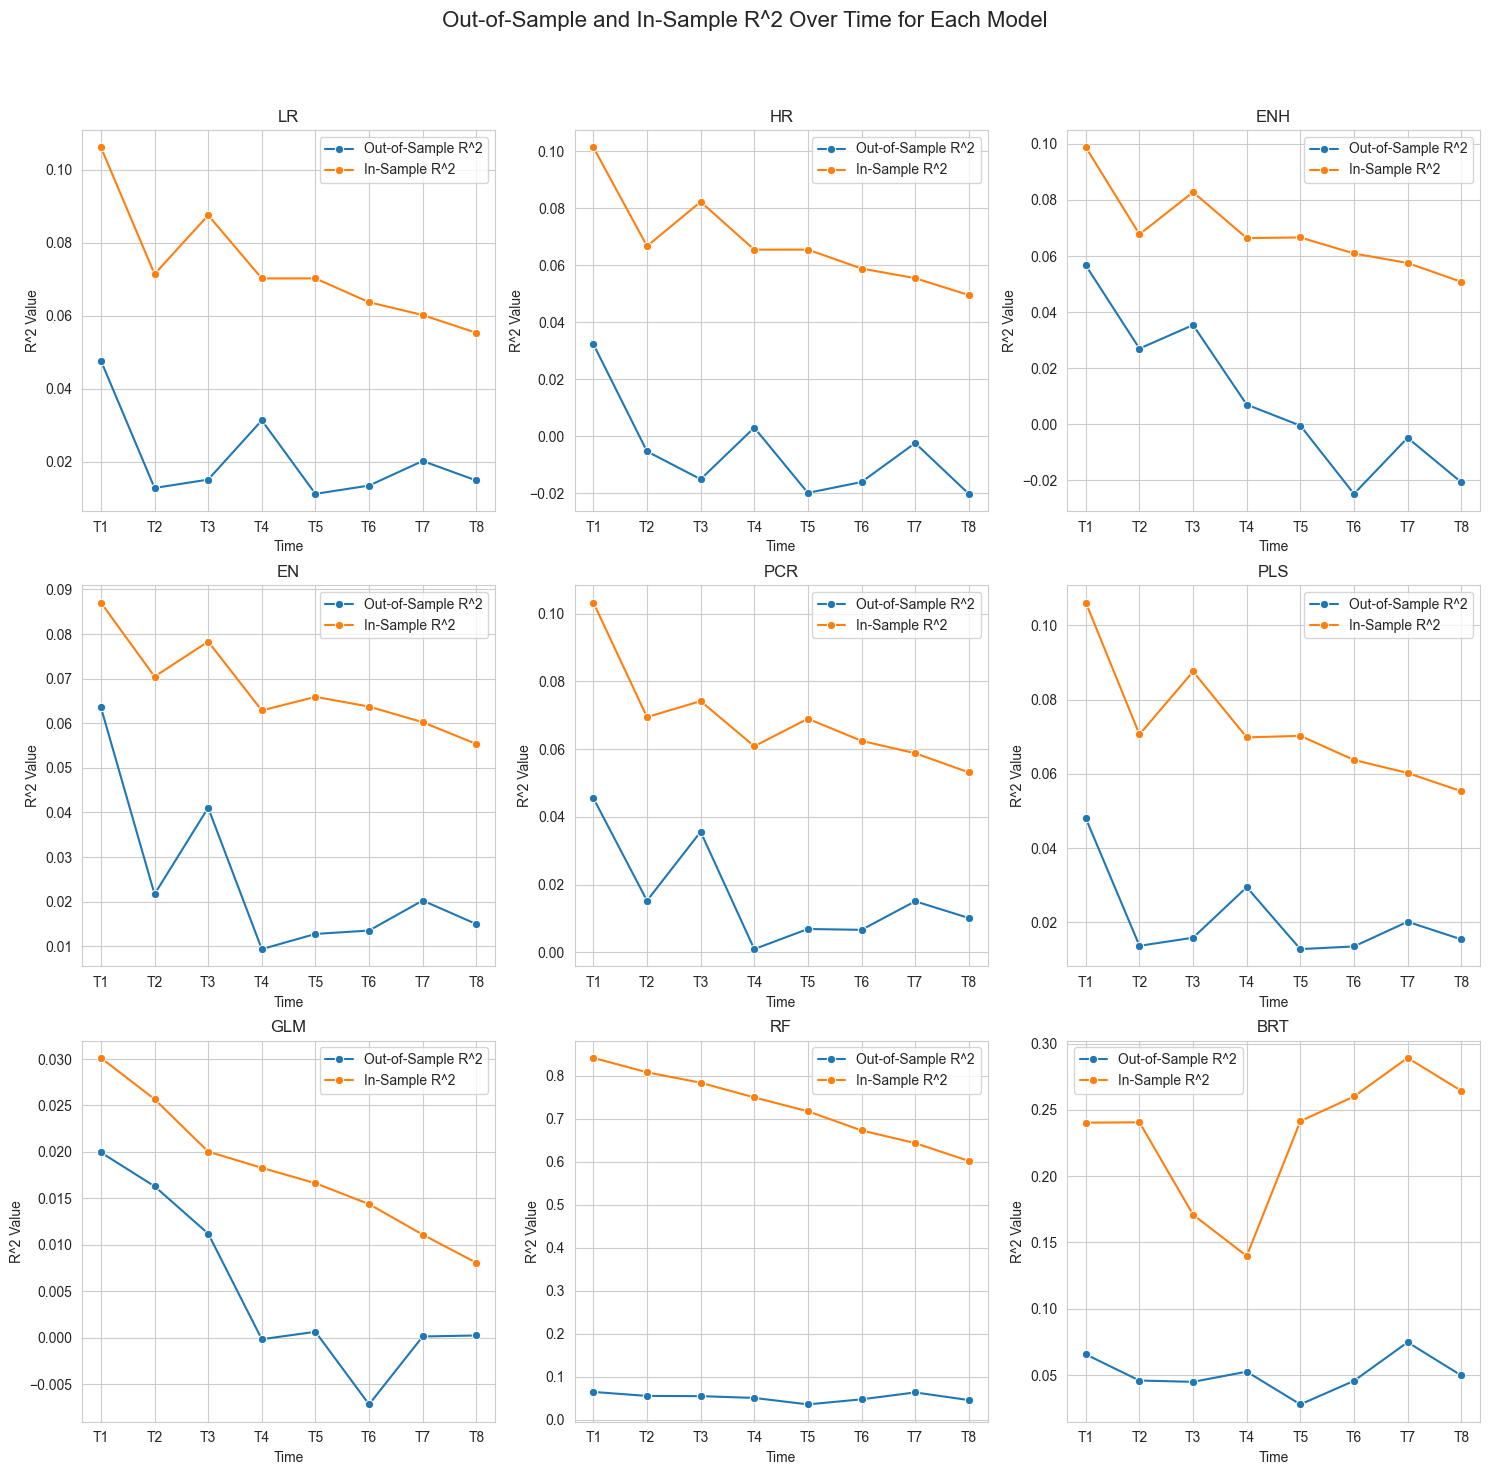

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


file_path = './output.xlsx'

outR2_df = pd.read_excel(file_path, 'outR^2')
oosR2_df = pd.read_excel(file_path, 'R^2oos')
inR2_df = pd.read_excel(file_path, 'inR^2')

sns.set_style("whitegrid")

# Function to plot 3x3 line charts for outR^2 and inR^2 together for each model
def plot_3x3_line_charts(out_df, in_df):


    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    fig.suptitle('Out-of-Sample and In-Sample R^2 Over Time for Each Model', fontsize=16)

    axes = axes.flatten()

    for i, model in enumerate(out_df.columns[1:]):
        sns.lineplot(data=out_df, x='Unnamed: 0', y=model, ax=axes[i], marker='o', label='Out-of-Sample R^2')
        sns.lineplot(data=in_df, x='Unnamed: 0', y=model, ax=axes[i], marker='o', label='In-Sample R^2')
        axes[i].set_title(model)
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('R^2 Value')
        axes[i].legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

plot_3x3_line_charts(outR2_df, inR2_df)

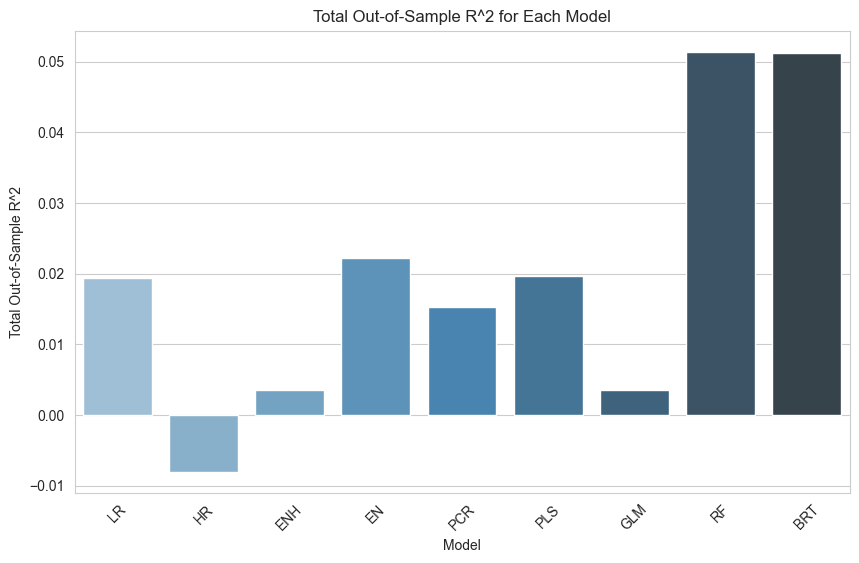

In [14]:
# Task 2: Plotting the histogram for R^2oos with the same color for each ba


plt.figure(figsize=(10, 6))
sns.barplot(data=oosR2_df, palette="Blues_d")
plt.title('Total Out-of-Sample R^2 for Each Model')
plt.xlabel('Model')
plt.ylabel('Total Out-of-Sample R^2')
plt.xticks(rotation=45)
plt.show()

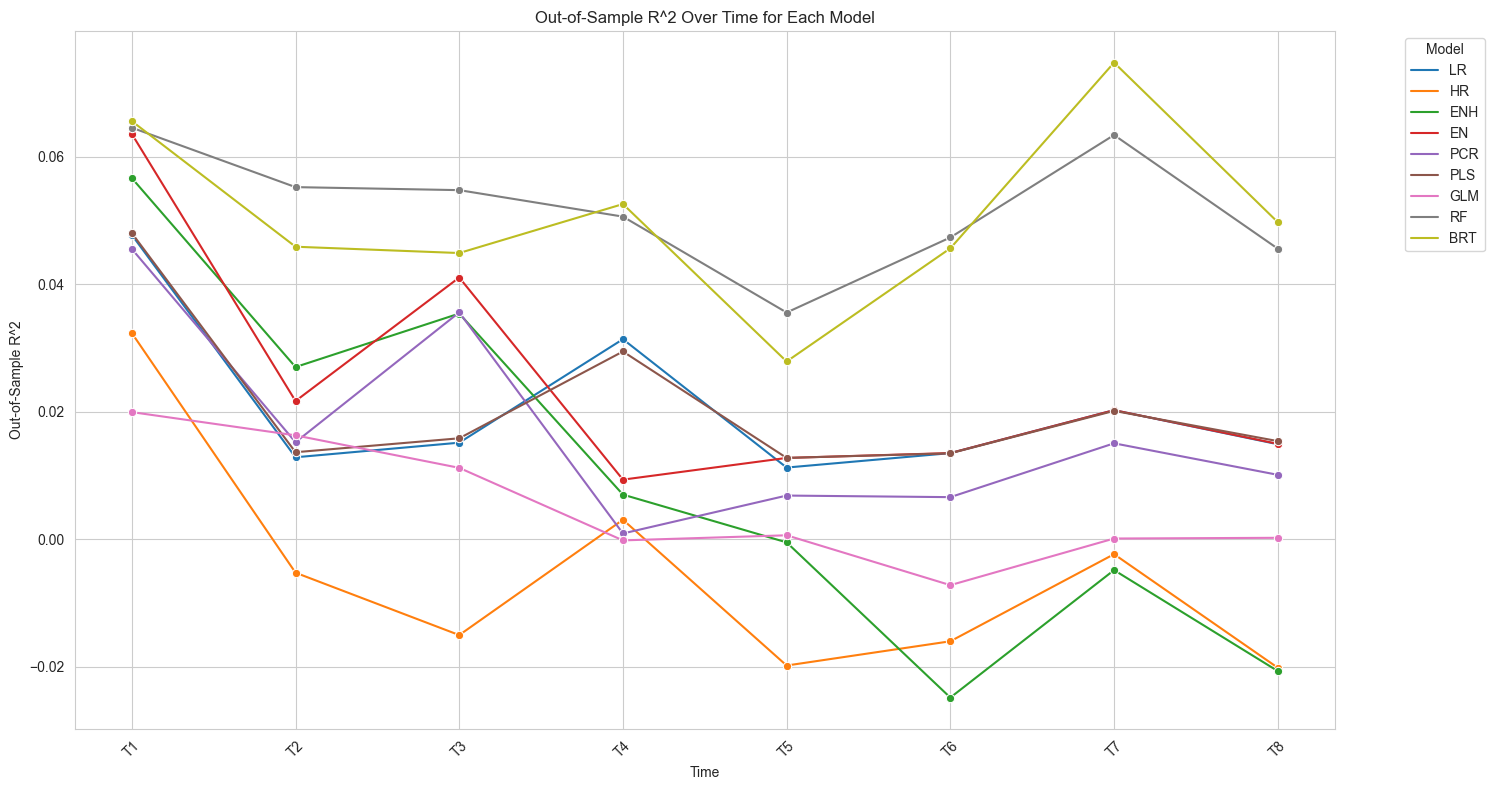

In [15]:
# Task 3: Preparing data for line plot of Out-of-Sample R^2
outR2_line_df = outR2_df.melt(id_vars=['Unnamed: 0'], var_name='Model', value_name='R^2')
outR2_line_df = outR2_line_df.rename(columns={'Unnamed: 0': 'Time'})


plt.figure(figsize=(15, 8))
sns.lineplot(data=outR2_line_df, x='Time', y='R^2', hue='Model', marker='o')
plt.title('Out-of-Sample R^2 Over Time for Each Model')
plt.xlabel('Time')
plt.ylabel('Out-of-Sample R^2')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
